# Threads fitting data

From the [threads documentation](https://palamaralab.github.io/software/threads/manual/#data-consistent-args) regarding fitting input mutations to the inferred ARG:

> Threads does not by default guarantee that input mutations correspond to 
> monophyletic clades in the inferred ARG. However, this can be achieved by 
> providing the `--fit_to_data` flag. When threads infer is run with the 
> `--fit_to_data` flag, the threading instructions are amended post-hoc such 
> that each input mutation is represented by a clade in a marginal coalescence 
> tree. As part of this process, Threads estimates the age of each mutation 
> and then amends the local ARG topology.

However, the time required to fit the data can be significant, especially for large datasets.
Another consideration is that when converting the ARG to a tree sequence, I can't 
use the `--add_mutations` if `--fit_to_data` is not used: this is why the 
[nf-treeseq](https://github.com/cnr-ibba/nf-treeseq) pipeline currently models 
the two distinct options with `--threads_fit_to_data` parameter.

Let's open the simplest results I have, with and without fitting the data, and 
try to understand the differences.

In [11]:
import tszip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tskitetude import get_project_dir

In [12]:
ts_threads = tszip.load(get_project_dir() / "results-threads/toInfer/threads/ts300I2k.1.trees.tsz")
ts_threads_fit = tszip.load(get_project_dir() / "results-threads/toInfer-fit/threads/ts300I2k.1.trees.tsz")

Let's dump the two tree sequences:

In [13]:
ts_threads

In [14]:
ts_threads_fit

The *fitted* version seems to see *bigger* than the normal one. Let's open also
the `tsinfer` version of treeseq:

In [15]:
ts_infer = tszip.load(get_project_dir() / "results-reference/toInfer/tsinfer/ts300I2k.1.trees.tsz")
ts_infer

Are *threads* file simplified? try to simplify them:

In [16]:
ts_threads_simplyfied = ts_threads.simplify()
ts_threads_fit_simplyfied = ts_threads_fit.simplify()

let's collect those information in a DataFrame for easier comparison:

In [17]:
ts_list = [ts_threads, ts_threads_simplyfied, ts_threads_fit, ts_threads_fit_simplyfied, ts_infer]

comparison_data = {
    'num_trees': [getattr(ts, 'num_trees') for ts in ts_list],
    'num_edges': [getattr(ts, 'num_edges') for ts in ts_list],
    'num_mutations': [getattr(ts, 'num_mutations') for ts in ts_list],
    'num_nodes': [getattr(ts, 'num_nodes') for ts in ts_list],
    'num_sites': [getattr(ts, 'num_sites') for ts in ts_list]
}

df_comparison = pd.DataFrame(comparison_data, index=[
    'threads', 'threads-simplified', 'threads-fit', 'threads-fit-simplified', 'infer'])
df_comparison.transpose()

,threads,threads-simplified,threads-fit,threads-fit-simplified,infer
num_trees,1949,1949,1999,1999,1905
num_edges,761436,428977,1979642,1117870,434206
num_mutations,0,0,1998,1998,280890
num_nodes,136628,136628,358846,358846,15647
num_sites,0,0,1998,1998,1999


Let's plot this dataframe:

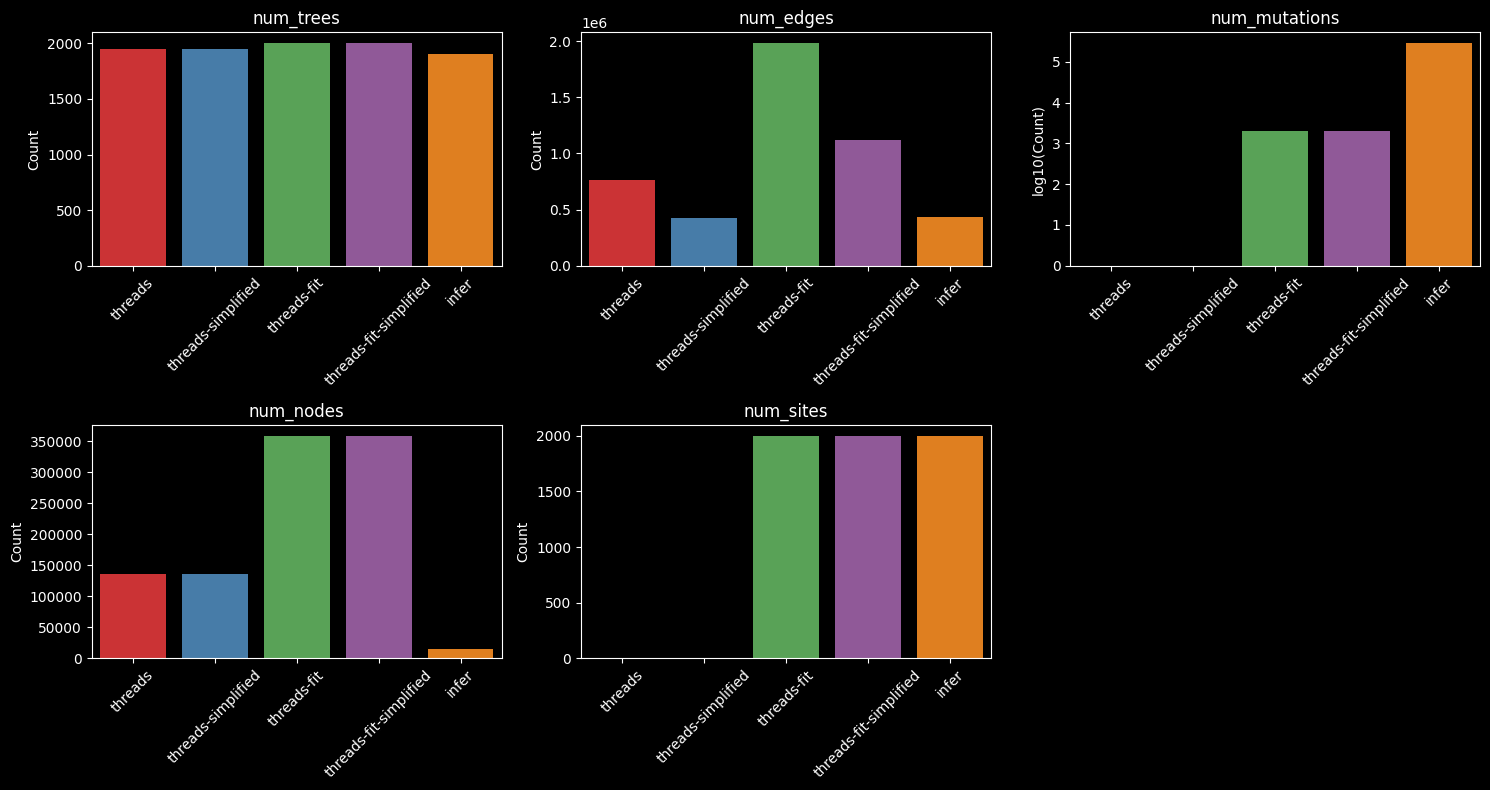

In [18]:
# A plot for each metric in a 2x3 grid with colors for each method (log scale)
metrics = df_comparison.columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Define colors for each method
colors = sns.color_palette("Set1", 5)

for i, metric in enumerate(metrics):
    data = df_comparison[[metric]].reset_index()
    data.columns = ['method', 'value']
    if metric in ['num_mutations']:
        data['value'] = np.log10(data['value'] + 1)
        axes[i].set_ylabel('log10(Count)')
    else:
        axes[i].set_ylabel('Count')
    sns.barplot(data=data, x='method', y='value', hue='method', ax=axes[i], palette=colors, legend=False)
    axes[i].set_title(metric)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Hide the last subplot (since we only have 5 metrics)
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

The number of threes are similar, between the two approaches (simplified or not). 
Number of edges differ: The *unfitted* version has less edges and *simplified* version 
has a number of edges similar to the *tsinfer* version. The *fitted* version and 
the *fitted-simplified* version have four and two times more edges than the *tsinfer*
version. The number of mutations and sites are missed in the *unfitted* version, while
the *fitted* version has more than half the mutations of the *tsinfer* version and 
the number of sites is similar. Lastly, the number of nodes is significantly higher
in the *unfitted* version and more higer in the *fitted* version compared to the *tsinfer* one.